In [1]:
using Revise
using ITensors,ITensorMPS
using PastaQ
using RandomMeas
using ProgressBars

In [2]:
N = 8
ξ = siteinds("Qubit", N)
B = 1.
ampo = AutoMPO()
for j in 1:(N - 1)
  # Ising ZZ interactions
  ampo .+= -1, "X", j, "X", j + 1
end
for j in 1:N
  # Transverse field X
  ampo .+= -B, "Z", j
end
H = MPO(ampo,ξ)
H2 = apply(H,H)
# Density-matrix renormalization group
dmrg_iter = 5      # DMRG steps
dmrg_cutoff = 1E-10   # Cutoff
ψ0 = randomMPS(ξ) # Initial state
sweeps = Sweeps(dmrg_iter)
maxdim!(sweeps, 10, 20, 30, 40, 50, 100)
cutoff!(sweeps, dmrg_cutoff)
# Run 
println("Running DMRG to get ground state of transverse field Ising model:")
E, ψ = dmrg(H, ψ0, sweeps)
println("\nGround state energy:  ", E)
println("\n---------------------------------------\n")

Running DMRG to get ground state of transverse field Ising model:
After sweep 1 energy=-9.712542551969243  maxlinkdim=4 maxerr=1.50E-16 time=15.011
After sweep 2 energy=-9.835955252705208  maxlinkdim=13 maxerr=2.93E-11 time=0.009
After sweep 3 energy=-9.83795105128921  maxlinkdim=9 maxerr=6.24E-11 time=0.008
After sweep 4 energy=-9.837951446183983  maxlinkdim=6 maxerr=9.29E-11 time=0.008
After sweep 5 energy=-9.837951446199053  maxlinkdim=6 maxerr=6.91E-11 time=0.008

Ground state energy:  -9.837951446199053

---------------------------------------



In [3]:
#Consider experimental state admixed with white noise
p = 0.05
Ide = MPO(ξ)
for i in 1:N
    Ide[i] = δ(ξ[i]',ξ[i])
end
ρ = (1-p)*outer(ψ',ψ)+p*Ide/2^N;

In [4]:
nu = 5000
NM = 1000
data = zeros(Int8,(nu,NM,N));

In [8]:
Es = 0.
E2s = 0.
n = 3 #We will create three batch shadows
u = Vector{Vector{ITensor}}()
ITensors.disable_warn_order()
for r in ProgressBar(1:nu, printing_delay=20)
        push!(u,get_rotations(ξ,1))
        data[r,:,:] =  get_RandomMeas(ρ,u[r],NM)
end

0.0%┣                                        ┫ 0/5.0k [00:03<-3:-29:-42, -3s/it]
0.0%┣                                         ┫ 1/5.0k [00:29<Inf:Inf, InfGs/it]
87.7%┣████████████████████████████████████     ┫ 4.4k/5.0k [00:49<00:07, 89it/s]
100.0%┣████████████████████████████████████████┫ 5.0k/5.0k [00:52<00:00, 96it/s]
100.0%┣████████████████████████████████████████┫ 5.0k/5.0k [00:52<00:00, 96it/s]


In [9]:
ρb = get_batch_shadows(data,ξ,u,n)
ρm = Vector{ITensor}(undef,n)
ρm[1] = (ρb[1]+ρb[2]+ρb[3])/3/nu
ρm[2] = (multiply(ρb[1],ρb[2])+multiply(ρb[1],ρb[3])+multiply(ρb[2],ρb[3]))/3/nu
ρm[3] = multiply(multiply(ρb[1],ρb[2]),ρb[3])/nu;

In [10]:
Es = zeros(n)
for nt in 1:n
    Es[nt] = real(trace(multiply(ρm[nt],flatten(H)),ξ)/trace(ρm[nt],ξ))
end

[-9.378247282369781, -9.877469418453778, -9.842802039189696]


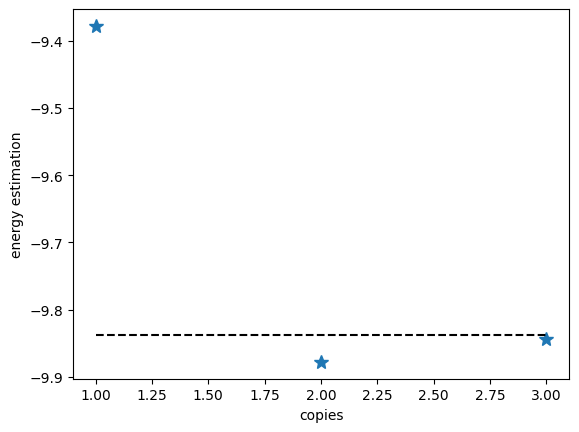

PyObject Text(24.000000000000007, 0.5, 'energy estimation')

In [11]:
println(Es)
using PyPlot
plot(1:n,Es,"*",ms=10)
plot(1:n,ones(n)*E,"--k")
xlabel("copies")
ylabel("energy estimation")